C:\Users\royti\AppData\Local\Temp\ipykernel_12940\12985910.py:58: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  site_boundary = buildable_area.unary_union
C:\Users\royti\AppData\Local\Temp\ipykernel_12940\12985910.py:138: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Легенда", loc="center left", bbox_to_anchor=(1.05, 0.5))


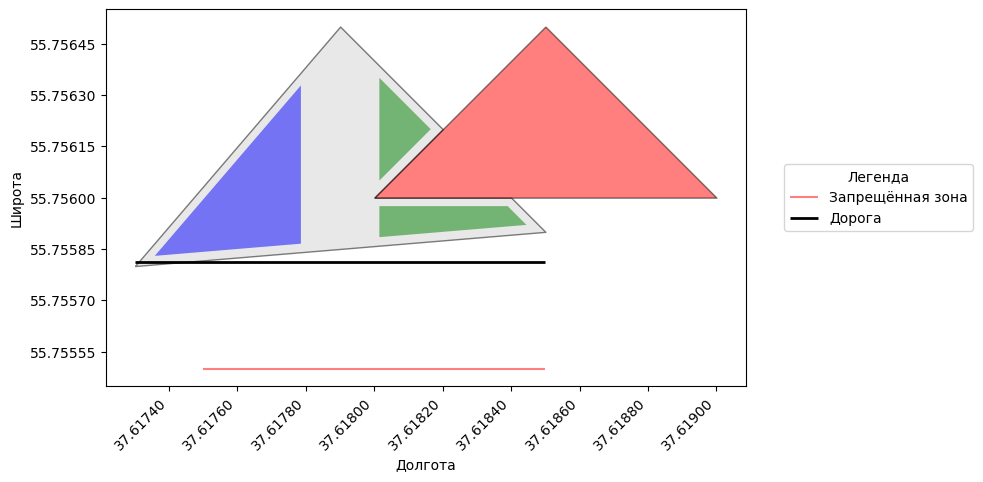

In [1]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, box
from shapely.ops import unary_union
import random

# Константы
MIN_DISTANCE_METERS = 10  # Минимальное расстояние между зданиями в метрах
DEGREES_PER_METER = 1 / 111320  # 1 градус ≈ 111320 метров
BUILDABLE_PERCENTAGE = 0.5  # Ограничение плотности застройки (например, 50% участка)

# Функция для разделения территории
def split_buildable_area(boundary, restricted_areas, buffer_distance, density_limit=BUILDABLE_PERCENTAGE):
    minx, miny, maxx, maxy = boundary.bounds
    split_x = (minx + maxx) / 2

    # Создаём потенциальные зоны
    residential_box = box(minx, miny, split_x - buffer_distance, maxy)
    commercial_box = box(split_x + buffer_distance, miny, maxx, maxy)

    # Учитываем ограничения
    residential_area = residential_box.intersection(boundary).difference(unary_union(restricted_areas.geometry))
    commercial_area = commercial_box.intersection(boundary).difference(unary_union(restricted_areas.geometry))

    # Ограничиваем плотность застройки
    total_area = boundary.area
    max_buildable_area = total_area * density_limit
    if residential_area.area + commercial_area.area > max_buildable_area:
        scale_factor = max_buildable_area / (residential_area.area + commercial_area.area)
        residential_area = residential_area.buffer(-buffer_distance * (1 - scale_factor))
        commercial_area = commercial_area.buffer(-buffer_distance * (1 - scale_factor))

    return residential_area, commercial_area

# Функция генерации дороги с проверкой
def generate_road(site_boundary, restricted_areas):
    minx, miny, maxx, maxy = site_boundary.bounds
    attempts = 10  # Ограничим количество попыток
    while attempts > 0:
        y = random.uniform(miny, maxy)
        road = LineString([(minx, y), (maxx, y)])
        if not any(restricted.intersects(road) for restricted in restricted_areas.geometry):
            return road
        attempts -= 1
    return None  # Если дорогу нельзя разместить, вернём None

# Загрузка данных
with open("input.geojson", "r", encoding="utf-8") as file:
    data = json.load(file)

# Преобразуем в GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data["features"])

# Выделение запрещённых зон и разрешённой зоны
restricted_areas = gdf[gdf["restriction"] == "no_build"]
buildable_area = gdf[gdf["restriction"].isna()]
site_boundary = buildable_area.unary_union

# "Очищаем" зону застройки от запрещённых зон
buildable_area_cleaned = site_boundary.difference(unary_union(restricted_areas.geometry))

# Разделяем зону на жилую и коммерческую с учётом ограничений
buffer_distance = MIN_DISTANCE_METERS * DEGREES_PER_METER
residential_area, commercial_area = split_buildable_area(buildable_area_cleaned, restricted_areas, buffer_distance)

# Генерация дороги
road = generate_road(buildable_area_cleaned, restricted_areas)

# Создание выходного GeoJSON
output_data = {
    "type": "FeatureCollection",
    "features": []
}

if residential_area:
    output_data["features"].append({
        "type": "Feature",
        "properties": {"type": "residential"},
        "geometry": residential_area.__geo_interface__
    })
if commercial_area:
    output_data["features"].append({
        "type": "Feature",
        "properties": {"type": "commercial"},
        "geometry": commercial_area.__geo_interface__
    })
if road:
    output_data["features"].append({
        "type": "Feature",
        "properties": {"type": "road"},
        "geometry": road.__geo_interface__
    })

with open("output.geojson", "w", encoding="utf-8") as file:
    json.dump(output_data, file, ensure_ascii=False, indent=2)

# Визуализация с улучшенной читаемостью
fig, ax = plt.subplots(figsize=(10, 8))

# Отображение зоны застройки
gpd.GeoSeries([buildable_area_cleaned]).plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Зона застройки')

# Отображение запрещённых зон
restricted_areas.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', label='Запрещённая зона')

# Отображение жилой зоны
if residential_area:
    gpd.GeoSeries([residential_area]).plot(ax=ax, color='blue', alpha=0.5, label='Жилая зона')

# Отображение коммерческой зоны
if commercial_area:
    gpd.GeoSeries([commercial_area]).plot(ax=ax, color='green', alpha=0.5, label='Коммерческая зона')

# Отображение дороги
if road:
    gpd.GeoSeries([road]).plot(ax=ax, color='black', linewidth=2, label='Дорога')

# Настройка осей для корректного отображения координат
ax.set_aspect('equal')

# Форматирование подписей осей (координаты в нормальном виде)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.5f'))  # 5 знаков после запятой
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.5f'))

# Поворот подписей по оси X (долгота) на 45 градусов
plt.xticks(rotation=45, ha='right')  # ha='right' выравнивает текст по правому краю

# Увеличение расстояния между подписями (настройка частоты меток)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Ограничиваем количество меток на оси X
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Ограничиваем количество меток на оси Y

# Улучшенные подписи
plt.xlabel("Долгота")
plt.ylabel("Широта")

# Перемещение легенды вправо за пределы графика
plt.legend(title="Легенда", loc="center left", bbox_to_anchor=(1.05, 0.5))

# Сохранение и вывод изображения
plt.tight_layout()  # Чтобы легенда и подписи не обрезались
plt.savefig("plan.png", dpi=300, bbox_inches='tight')
plt.show()